In [1]:
from pathlib import Path
import pandas as pd

In [4]:
from pathlib import Path
import pandas as pd

# ==============================
# Step 1: Load dataset
# ==============================
try:
    script_dir = Path(__file__).resolve().parent
except NameError:
    script_dir = Path.cwd()

def find_data_process_dir(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / "Data_Warehouse").exists():
            return p
    raise FileNotFoundError("Could not locate Data_Warehouse folder")

data_process_dir = find_data_process_dir(script_dir)
warehouse_dir = data_process_dir / "Data_Warehouse"

file_path = warehouse_dir / "combined_mental_condition_dataset.csv"
df = pd.read_csv(file_path)

print(f"✅ Loaded dataset from {file_path}")
print(f"Rows: {len(df)}")
print(df.sample(5))


✅ Loaded dataset from d:\Sajjad-Workspace\PSS_XAI\Data_Process\Data_Warehouse\combined_mental_condition_dataset.csv
Rows: 9468
                                                   text       label
2211  I tried yesterday, I take almost 30 pills of s...  depression
6285  According to the Bush Administration, Iraq War...      stress
5747               I haven't been sleeping well lately.      stress
7372  hi dr..i just so stressful due to my project w...      stress
1604  Ashamed of being depressed.\nI've never been "...  depression


In [5]:
# ==============================
# Step 2: Basic statistics
# ==============================
# Unique text check
unique_texts = df["text"].nunique()
duplicates = len(df) - unique_texts

# Label distribution
label_counts = df["label"].value_counts()

# Text length statistics
df["word_count"] = df["text"].astype(str).str.split().apply(len)
df["char_count"] = df["text"].astype(str).str.len()

length_stats = df.groupby("label")[["word_count", "char_count"]].agg(["mean", "median", "min", "max"])

print("\n=== Dataset Overview ===")
print(f"Total rows: {len(df)}")
print(f"Unique texts: {unique_texts}")
print(f"Duplicate texts: {duplicates}")

print("\n=== Label Distribution ===")
print(label_counts)

print("\n=== Text Length Stats (per label) ===")
print(length_stats)



=== Dataset Overview ===
Total rows: 9468
Unique texts: 9463
Duplicate texts: 5

=== Label Distribution ===
label
stress        4771
depression    2322
suicide        838
none           707
anxiety        416
ptsd           414
Name: count, dtype: int64

=== Text Length Stats (per label) ===
            word_count                  char_count                  
                  mean median min  max        mean median min    max
label                                                               
anxiety      88.762019   84.0   1  260  463.245192  438.0   6   1354
depression  141.977606  119.0   1  400  733.395349  613.0   9   2486
none         61.751061   52.0   0  359  343.264498  285.0   1   1967
ptsd         84.038647   80.0   1  256  440.362319  421.0   6   1271
stress       29.396353   14.0   1  310  151.075875   72.0   3   1639
suicide     117.131265   86.0   1  398  627.752983  440.5   4  24586


In [ ]:
# ==============================
# Step 3: Count texts with < 15 words by label
# ==============================
short_texts = df[df["word_count"] < 15]
short_counts = short_texts["label"].value_counts()

print("\n=== Counts of texts with < 10 words per label ===")
print(short_counts)



=== Counts of texts with < 10 words per label ===
label
stress        2497
suicide         63
depression      61
none            57
anxiety          2
ptsd             1
Name: count, dtype: int64


In [12]:
# ==============================
# Step 3: Remove short texts (< 15 words) for stress only
# ==============================
THRESH = 15

if "word_count" not in df.columns:
    df["word_count"] = df["text"].astype(str).str.split().apply(len)

before_counts = df["label"].value_counts()

mask_remove = (df["label"] == "stress") & (df["word_count"] < THRESH)
removed_rows = int(mask_remove.sum())

df_reduced = df.loc[~mask_remove].copy()

print("\n=== Stress short text removal report ===")
print(f"Removed rows from stress: {removed_rows}")
print("\nCounts by label before removal:")
print(before_counts)
print("\nCounts by label after removal:")
print(df_reduced["label"].value_counts())

# ==============================
# Step 4: Save the reduced dataset to CSV
# ==============================
def get_unique_path(base_dir: Path, base_name: str) -> Path:
    out_path = base_dir / base_name
    if not out_path.exists():
        return out_path
    stem, ext = base_name.rsplit(".", 1)
    i = 2
    while True:
        candidate = base_dir / f"{stem}_{i}.{ext}"
        if not candidate.exists():
            return candidate
        i += 1

out_path = get_unique_path(warehouse_dir, "combined_mental_condition_dataset_balanced.csv")
df_reduced.to_csv(out_path, index=False)

print(f"\nSaved reduced dataset to: {out_path}")



=== Stress short text removal report ===
Removed rows from stress: 2497

Counts by label before removal:
label
stress        4771
depression    2322
suicide        838
none           707
anxiety        416
ptsd           414
Name: count, dtype: int64

Counts by label after removal:
label
depression    2322
stress        2274
suicide        838
none           707
anxiety        416
ptsd           414
Name: count, dtype: int64

Saved reduced dataset to: d:\Sajjad-Workspace\PSS_XAI\Data_Process\Data_Warehouse\combined_mental_condition_dataset_balanced.csv


In [13]:
# ==============================
# Step 5: Build sentence embeddings with BERT large uncased
# ==============================
import torch
from transformers import BertTokenizer, BertModel
import numpy as np

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "google-bert/bert-large-uncased"
BATCH_SIZE = 16

# choose the working dataframe: df_reduced if it exists, else df
try:
    data_df = df_reduced.copy()
except NameError:
    data_df = df.copy()

texts = data_df["text"].astype(str).tolist()
labels = data_df["label"].astype(str).tolist()

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertModel.from_pretrained(MODEL_NAME)
model.to(DEVICE)
model.eval()

def mean_pool(last_hidden_state, attention_mask):
    mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
    masked = last_hidden_state * mask
    summed = masked.sum(dim=1)
    counts = mask.sum(dim=1).clamp(min=1e-9)
    return summed / counts

emb_list = []
with torch.no_grad():
    for i in range(0, len(texts), BATCH_SIZE):
        batch_texts = texts[i:i+BATCH_SIZE]
        enc = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=256,
            return_tensors="pt"
        ).to(DEVICE)

        outputs = model(**enc)
        # mean pooling over tokens using attention mask
        pooled = mean_pool(outputs.last_hidden_state, enc["attention_mask"])
        emb_list.append(pooled.cpu().numpy())

embeddings = np.vstack(emb_list).astype(np.float32)

# optional: save raw embeddings
np.save(warehouse_dir / "text_embeddings_bert_large.npy", embeddings)


c:\Users\nipua\AppData\Local\anaconda3\envs\py312_xai\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\nipua\.cache\huggingface\hub\models--google-bert--bert-large-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Fal


✅ Saved 2D plot to: d:\Sajjad-Workspace\PSS_XAI\Data_Process\Data_Warehouse\text_embeddings_2d_bert_large_tsne.png


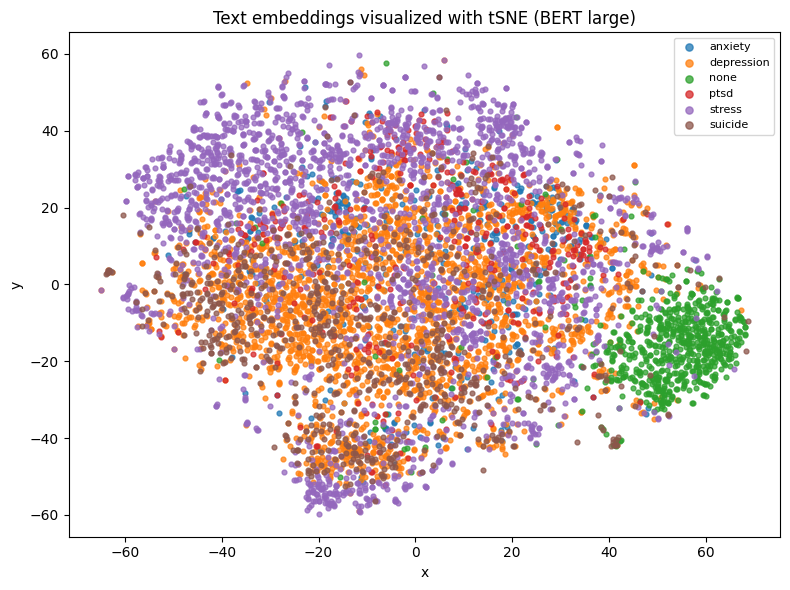

In [14]:
# ==============================
# Step 6: Reduce dimensionality
# ==============================
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# first compress to 50 dims with PCA for stability and speed
pca_50 = PCA(n_components=50, random_state=42)
emb_50 = pca_50.fit_transform(embeddings)

# then project to 2D with tSNE
tsne_2d = TSNE(n_components=2, init="pca", learning_rate="auto", perplexity=30, random_state=42)
coords_2d = tsne_2d.fit_transform(emb_50)

# optional: save 2D coordinates with labels
out_2d = pd.DataFrame({"x": coords_2d[:,0], "y": coords_2d[:,1], "label": labels, "text": texts})
#out_2d.to_csv(warehouse_dir / "text_embeddings_2d_bert_large_tsne.csv", index=False)

# ==============================
# Step 7: Visualize
# ==============================
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for lab in sorted(out_2d["label"].unique()):
    sub = out_2d[out_2d["label"] == lab]
    plt.scatter(sub["x"], sub["y"], s=12, label=lab, alpha=0.75)

plt.title("Text embeddings visualized with tSNE (BERT large)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(markerscale=1.5, fontsize=8)
plt.tight_layout()

plot_path = warehouse_dir / "text_embeddings_2d_bert_large_tsne.png"
plt.savefig(plot_path, dpi=150)
print(f"\n✅ Saved 2D plot to: {plot_path}")
#print(f"✅ Saved 2D coordinates to: {warehouse_dir / 'text_embeddings_2d_bert_large_tsne.csv'}")


Loading model: sentence-transformers/all-mpnet-base-v2


Batches: 100%|██████████| 109/109 [00:41<00:00,  2.65it/s]
c:\Users\nipua\AppData\Local\anaconda3\envs\py312_xai\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\nipua\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)



Loading model: sentence-transformers/all-MiniLM-L6-v2


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Batches: 100%|██████████| 109/109 [00:10<00:00, 10.79it/s]
c:\Users\nipua\AppData\Local\anaconda3\envs\py312_xai\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\nipua\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L12-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer 


Loading model: sentence-transformers/all-MiniLM-L12-v2


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Batches: 100%|██████████| 109/109 [00:11<00:00,  9.16it/s]
c:\Users\nipua\AppData\Local\anaconda3\envs\py312_xai\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ Finished computing embeddings for all models.

Reducing dims for sentence-transformers/all-mpnet-base-v2
Saved 2D coordinates to: d:\Sajjad-Workspace\PSS_XAI\Data_Process\Data_Warehouse\embeddings2d_all-mpnet-base-v2_umap.csv

Reducing dims for sentence-transformers/all-MiniLM-L6-v2


c:\Users\nipua\AppData\Local\anaconda3\envs\py312_xai\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved 2D coordinates to: d:\Sajjad-Workspace\PSS_XAI\Data_Process\Data_Warehouse\embeddings2d_all-MiniLM-L6-v2_umap.csv

Reducing dims for sentence-transformers/all-MiniLM-L12-v2


c:\Users\nipua\AppData\Local\anaconda3\envs\py312_xai\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved 2D coordinates to: d:\Sajjad-Workspace\PSS_XAI\Data_Process\Data_Warehouse\embeddings2d_all-MiniLM-L12-v2_umap.csv
✅ Saved plot for all-mpnet-base-v2 to: d:\Sajjad-Workspace\PSS_XAI\Data_Process\Data_Warehouse\plot2d_all-mpnet-base-v2.png
✅ Saved plot for all-MiniLM-L6-v2 to: d:\Sajjad-Workspace\PSS_XAI\Data_Process\Data_Warehouse\plot2d_all-MiniLM-L6-v2.png
✅ Saved plot for all-MiniLM-L12-v2 to: d:\Sajjad-Workspace\PSS_XAI\Data_Process\Data_Warehouse\plot2d_all-MiniLM-L12-v2.png
✅ Saved side by side comparison to: d:\Sajjad-Workspace\PSS_XAI\Data_Process\Data_Warehouse\plots2d_sbert_comparison.png


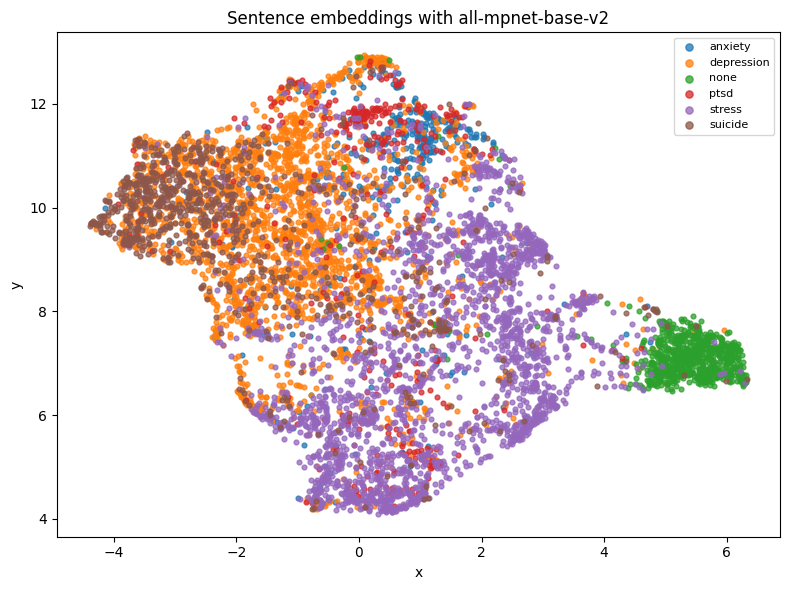

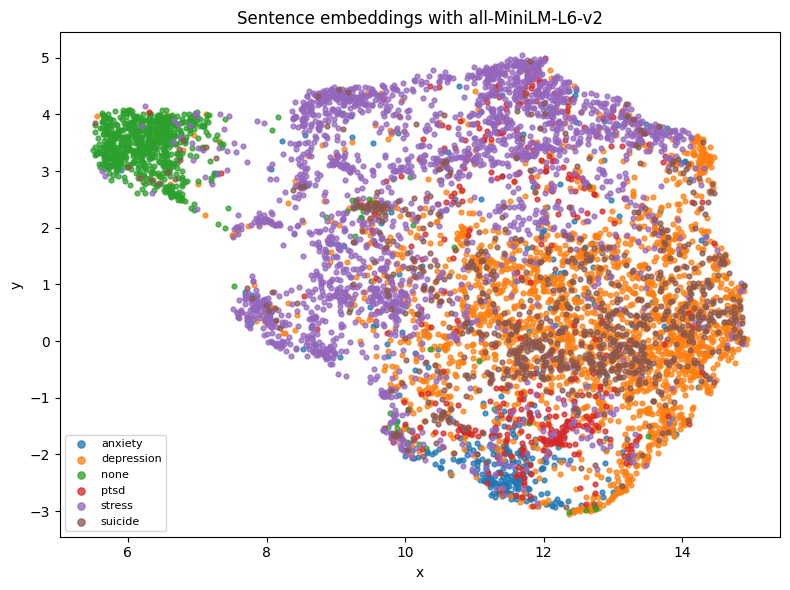

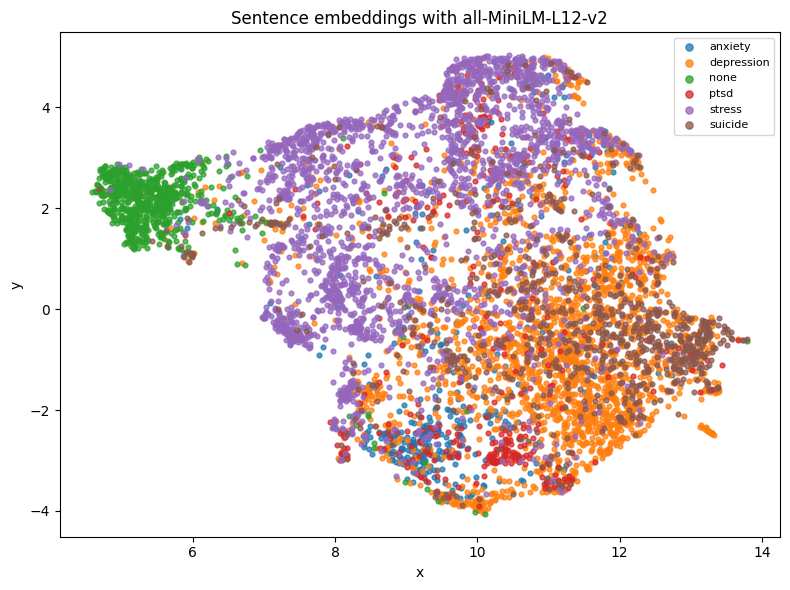

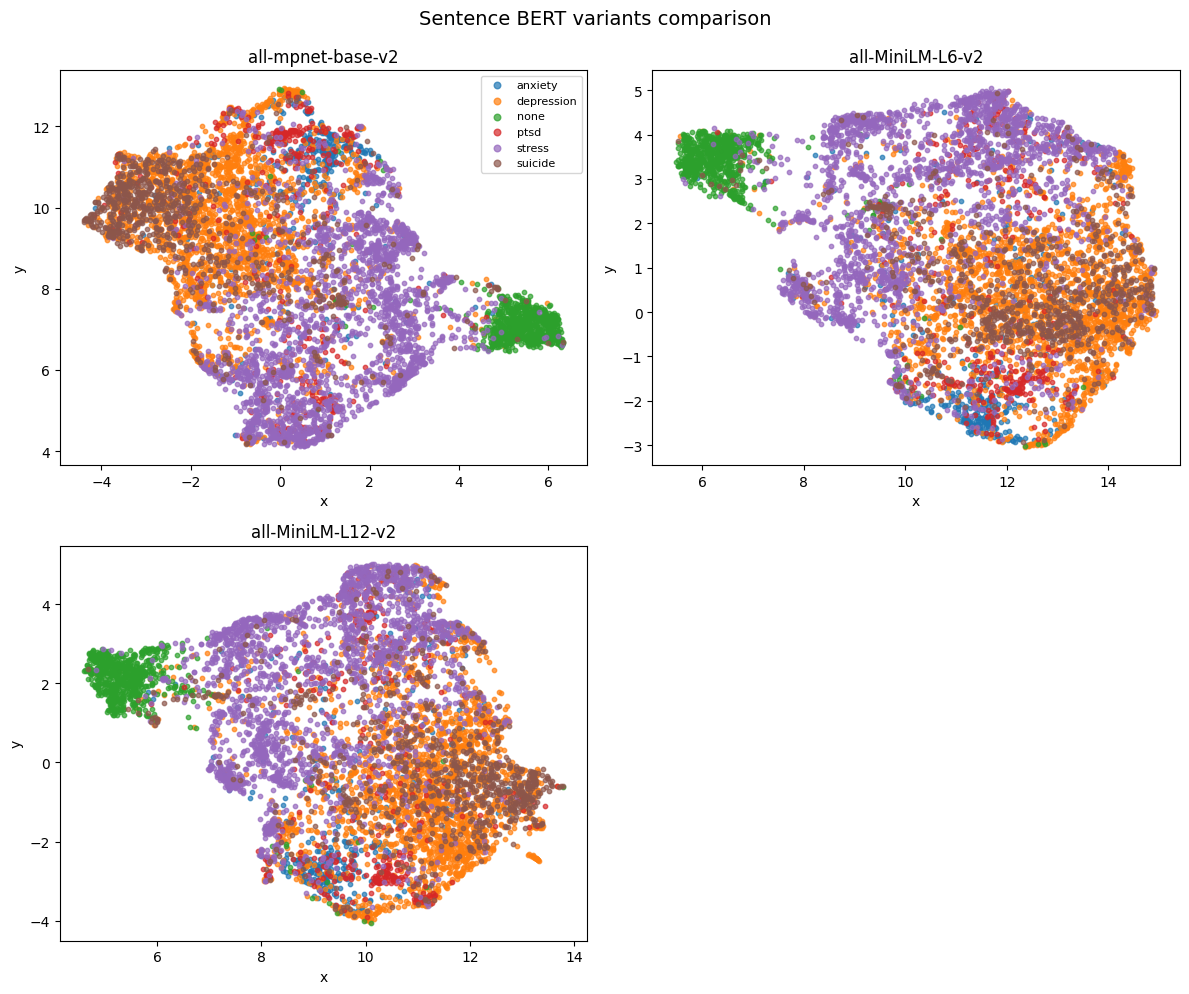

In [17]:
# ==============================
# Step 5: Sentence embeddings with Sentence-BERT variants
# ==============================
import torch
import numpy as np
import pandas as pd
from pathlib import Path

try:
    from sentence_transformers import SentenceTransformer
except ImportError as e:
    raise ImportError(
        "Please install sentence-transformers first:\n"
        "pip install -U sentence-transformers"
    ) from e

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64

# choose working dataframe
try:
    data_df = df_reduced.copy()
except NameError:
    data_df = df.copy()

texts = data_df["text"].astype(str).tolist()
labels = data_df["label"].astype(str).tolist()

# pick a set of strong general purpose models
sbert_models = [
    "sentence-transformers/all-mpnet-base-v2",   # very strong general purpose
    "sentence-transformers/all-MiniLM-L6-v2",    # fast and light
    "sentence-transformers/all-MiniLM-L12-v2",   # a bit larger than L6
]

embeddings_by_model = {}
for model_name in sbert_models:
    print(f"\nLoading model: {model_name}")
    st_model = SentenceTransformer(model_name, device=DEVICE)
    # encode with mean pooling and length normalization
    emb = st_model.encode(
        texts,
        batch_size=BATCH_SIZE,
        convert_to_numpy=True,
        normalize_embeddings=True,
        show_progress_bar=True,
    )
    embeddings_by_model[model_name] = emb
    np.save(warehouse_dir / f"embeddings_{model_name.split('/')[-1]}.npy", emb)

print("✅ Finished computing embeddings for all models.")

# ==============================
# Step 6: Dimensionality reduction (PCA then UMAP or TSNE)
# ==============================
from sklearn.decomposition import PCA

# try UMAP first for nicer global and local structure, else fall back to TSNE
use_umap = False
try:
    import umap
    use_umap = True
except Exception:
    from sklearn.manifold import TSNE

coords_by_model = {}
for model_name, emb in embeddings_by_model.items():
    print(f"\nReducing dims for {model_name}")
    # compress to 50 with PCA for stability and speed
    pca_50 = PCA(n_components=50, random_state=42)
    emb_50 = pca_50.fit_transform(emb)

    if use_umap:
        reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
        coords_2d = reducer.fit_transform(emb_50)
        method_tag = "umap"
    else:
        reducer = TSNE(n_components=2, init="pca", learning_rate="auto", perplexity=30, random_state=42)
        coords_2d = reducer.fit_transform(emb_50)
        method_tag = "tsne"

    coords_by_model[model_name] = coords_2d
    # save per model csv with coordinates
    df_2d = pd.DataFrame({
        "x": coords_2d[:, 0],
        "y": coords_2d[:, 1],
        "label": labels,
        "text": texts
    })
    out_csv = warehouse_dir / f"embeddings2d_{model_name.split('/')[-1]}_{method_tag}.csv"
    df_2d.to_csv(out_csv, index=False)
    print(f"Saved 2D coordinates to: {out_csv}")

# ==============================
# Step 7: Visualize each model separately
# ==============================
import matplotlib.pyplot as plt

for model_name, coords in coords_by_model.items():
    df_plot = pd.DataFrame({"x": coords[:, 0], "y": coords[:, 1], "label": labels})
    plt.figure(figsize=(8, 6))
    for lab in sorted(df_plot["label"].unique()):
        sub = df_plot[df_plot["label"] == lab]
        plt.scatter(sub["x"], sub["y"], s=12, label=lab, alpha=0.75)
    title_model = model_name.split("/")[-1]
    plt.title(f"Sentence embeddings with {title_model}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend(markerscale=1.5, fontsize=8)
    plt.tight_layout()
    out_png = warehouse_dir / f"plot2d_{title_model}.png"
    plt.savefig(out_png, dpi=150)
    print(f"✅ Saved plot for {title_model} to: {out_png}")

# ==============================
# Step 8: Optional comparison on a single figure
# ==============================
# makes a grid of subplots to compare models at a glance
import math

n = len(coords_by_model)
cols = 2
rows = math.ceil(n / cols)
plt.figure(figsize=(6 * cols, 5 * rows))

for i, (model_name, coords) in enumerate(coords_by_model.items(), start=1):
    df_plot = pd.DataFrame({"x": coords[:, 0], "y": coords[:, 1], "label": labels})
    ax = plt.subplot(rows, cols, i)
    for lab in sorted(df_plot["label"].unique()):
        sub = df_plot[df_plot["label"] == lab]
        ax.scatter(sub["x"], sub["y"], s=10, label=lab, alpha=0.7)
    title_model = model_name.split("/")[-1]
    ax.set_title(title_model)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    if i == 1:
        ax.legend(markerscale=1.5, fontsize=8)

plt.suptitle("Sentence BERT variants comparison", y=0.99, fontsize=14)
plt.tight_layout()
combo_png = warehouse_dir / "plots2d_sbert_comparison.png"
plt.savefig(combo_png, dpi=150)
print(f"✅ Saved side by side comparison to: {combo_png}")


### Intrinsic Evaluation (Clustering quality)

In [20]:
# ==============================
# Step X: Load BERT-large embeddings and compare with SBERT variants
# ==============================
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
)

# reload raw BERT embeddings you saved earlier
bert_large_path = warehouse_dir / "text_embeddings_bert_large.npy"
if bert_large_path.exists():
    bert_large_emb = np.load(bert_large_path)
    embeddings_by_model["google-bert/bert-large-uncased"] = bert_large_emb
    print(f"✅ Loaded existing BERT-large embeddings from {bert_large_path}")
else:
    print("⚠️ Could not find bert_large embeddings .npy file. Skipping.")

# encode labels to integers for external metrics
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_true = le.fit_transform(labels)
n_clusters = len(le.classes_)

def evaluate_model_embeddings(emb: np.ndarray, y_true_int: np.ndarray, k: int) -> dict:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    y_pred = km.fit_predict(emb)

    return {
        "silhouette": silhouette_score(emb, y_pred),
        "davies_bouldin": davies_bouldin_score(emb, y_pred),
        "calinski_harabasz": calinski_harabasz_score(emb, y_pred),
        "adjusted_rand_index": adjusted_rand_score(y_true_int, y_pred),
        "normalized_mutual_info": normalized_mutual_info_score(y_true_int, y_pred),
    }

rows = []
for model_name, emb in embeddings_by_model.items():
    print(f"Evaluating clustering quality for {model_name}")
    scores = evaluate_model_embeddings(emb, y_true, n_clusters)
    row = {"model": model_name}
    row.update(scores)
    rows.append(row)

results_df = pd.DataFrame(rows)
results_df = results_df.sort_values(by="silhouette", ascending=False).reset_index(drop=True)

print("\n=== Clustering quality comparison across embedding models ===")
print(results_df)

out_csv = warehouse_dir / "embedding_model_clustering_scores.csv"
results_df.to_csv(out_csv, index=False)
print(f"\nSaved clustering scores to: {out_csv}")



✅ Loaded existing BERT-large embeddings from d:\Sajjad-Workspace\PSS_XAI\Data_Process\Data_Warehouse\text_embeddings_bert_large.npy
Evaluating clustering quality for sentence-transformers/all-mpnet-base-v2
Evaluating clustering quality for sentence-transformers/all-MiniLM-L6-v2
Evaluating clustering quality for sentence-transformers/all-MiniLM-L12-v2
Evaluating clustering quality for google-bert/bert-large-uncased

=== Clustering quality comparison across embedding models ===
                                     model  silhouette  davies_bouldin  \
0  sentence-transformers/all-mpnet-base-v2    0.024554        4.259530   
1   sentence-transformers/all-MiniLM-L6-v2    0.024220        4.214453   
2  sentence-transformers/all-MiniLM-L12-v2    0.021218        4.338217   
3           google-bert/bert-large-uncased    0.004662        3.830768   

   calinski_harabasz  adjusted_rand_index  normalized_mutual_info  
0         183.172246             0.250598                0.336166  
1         18

Best overall: sentence-transformers/all-mpnet-base-v2 — best silhouette, ARI, and NMI (the most important when labels exist).

Runner-up: all-MiniLM-L6-v2 — nearly the same as mpnet but faster and smaller.

Raw BERT large: despite good DBI and CH scores, its ARI and NMI are much lower, meaning it doesn’t capture your label structure well.

### Extrinsic Evaluation (Classification quality)

In [21]:
# ==============================
# Approach 2: Extrinsic evaluation with classification
# Uses embeddings as features for a simple classifier
# Produces holdout and cross validation scores for each model
# Saves per model confusion matrix and per class metrics
# ==============================
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)

# prerequisites in memory
# - embeddings_by_model: dict with model name to numpy array [n_samples, dim]
# - labels: list of string labels aligned to rows
# - warehouse_dir: Path to your Data Warehouse

# encode labels
le = LabelEncoder()
y = le.fit_transform(labels)
class_names = list(le.classes_)
n_classes = len(class_names)

# helper to create safe file tags for names like sentence-transformers/all-mpnet-base-v2
def safe_tag(name: str) -> str:
    return name.replace("/", "_").replace(":", "_")

# holdout split
X_train_idx, X_test_idx, y_train, y_test = train_test_split(
    np.arange(len(y)), y, test_size=0.2, random_state=42, stratify=y
)

holdout_rows = []
cv_rows = []

# classifier config
# saga handles many classes and supports l1 l2 elastic net and can use probability
clf_base = LogisticRegression(
    max_iter=5000,
    solver="saga",
    n_jobs=-1,
    multi_class="auto"
)

for model_name, X in embeddings_by_model.items():
    tag = safe_tag(model_name)
    print(f"\n=== Evaluating classifier with embeddings from: {model_name} ===")

    # split features
    X_train = X[X_train_idx]
    X_test = X[X_test_idx]

    # train
    clf = clf_base
    clf.fit(X_train, y_train)

    # predict
    y_pred = clf.predict(X_test)

    # base metrics
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average="macro")
    f1_weighted = f1_score(y_test, y_pred, average="weighted")

    # per class report
    report = classification_report(
        y_test, y_pred, target_names=class_names, output_dict=True, zero_division=0
    )
    report_df = pd.DataFrame(report).transpose()

    # confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

    # ROC AUC one vs rest if probabilities available
    try:
        y_prob = clf.predict_proba(X_test)
        y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
        if n_classes == 2:
            roc_auc = roc_auc_score(y_test, y_prob[:, 1])
        else:
            roc_auc = roc_auc_score(y_test_bin, y_prob, average="macro", multi_class="ovr")
    except Exception:
        roc_auc = np.nan

    # record holdout row
    holdout_rows.append({
        "model": model_name,
        "accuracy": acc,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "roc_auc_ovr": roc_auc,
    })

    # save artifacts
    out_report = warehouse_dir / f"classifier_report_{tag}.csv"
    out_cm = warehouse_dir / f"confusion_matrix_{tag}.csv"
    report_df.to_csv(out_report, index=True)
    cm_df.to_csv(out_cm, index=True)
    print(f"Saved per class report to: {out_report}")
    print(f"Saved confusion matrix to: {out_cm}")

    # cross validation for robustness
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_validate(
        clf_base, X, y,
        cv=skf,
        scoring={"acc": "accuracy", "f1_macro": "f1_macro", "f1_weighted": "f1_weighted"},
        n_jobs=-1,
        return_train_score=False
    )
    cv_rows.append({
        "model": model_name,
        "cv_acc_mean": float(np.mean(cv_scores["test_acc"])),
        "cv_acc_std": float(np.std(cv_scores["test_acc"])),
        "cv_f1_macro_mean": float(np.mean(cv_scores["test_f1_macro"])),
        "cv_f1_macro_std": float(np.std(cv_scores["test_f1_macro"])),
        "cv_f1_weighted_mean": float(np.mean(cv_scores["test_f1_weighted"])),
        "cv_f1_weighted_std": float(np.std(cv_scores["test_f1_weighted"])),
    })

# summarize and save
holdout_df = pd.DataFrame(holdout_rows).sort_values(by="f1_macro", ascending=False).reset_index(drop=True)
cv_df = pd.DataFrame(cv_rows).sort_values(by="cv_f1_macro_mean", ascending=False).reset_index(drop=True)

out_holdout = warehouse_dir / "embedding_model_classification_scores_holdout.csv"
out_cv = warehouse_dir / "embedding_model_classification_scores_cv.csv"
holdout_df.to_csv(out_holdout, index=False)
cv_df.to_csv(out_cv, index=False)

print("\n=== Holdout results ===")
print(holdout_df)
print("\n=== Cross validation results ===")
print(cv_df)
print(f"\nSaved holdout table to: {out_holdout}")
print(f"Saved cross validation table to: {out_cv}")



=== Evaluating classifier with embeddings from: sentence-transformers/all-mpnet-base-v2 ===


c:\Users\nipua\AppData\Local\anaconda3\envs\py312_xai\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Saved per class report to: d:\Sajjad-Workspace\PSS_XAI\Data_Process\Data_Warehouse\classifier_report_sentence-transformers_all-mpnet-base-v2.csv
Saved confusion matrix to: d:\Sajjad-Workspace\PSS_XAI\Data_Process\Data_Warehouse\confusion_matrix_sentence-transformers_all-mpnet-base-v2.csv

=== Evaluating classifier with embeddings from: sentence-transformers/all-MiniLM-L6-v2 ===


c:\Users\nipua\AppData\Local\anaconda3\envs\py312_xai\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Saved per class report to: d:\Sajjad-Workspace\PSS_XAI\Data_Process\Data_Warehouse\classifier_report_sentence-transformers_all-MiniLM-L6-v2.csv
Saved confusion matrix to: d:\Sajjad-Workspace\PSS_XAI\Data_Process\Data_Warehouse\confusion_matrix_sentence-transformers_all-MiniLM-L6-v2.csv

=== Evaluating classifier with embeddings from: sentence-transformers/all-MiniLM-L12-v2 ===


c:\Users\nipua\AppData\Local\anaconda3\envs\py312_xai\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Saved per class report to: d:\Sajjad-Workspace\PSS_XAI\Data_Process\Data_Warehouse\classifier_report_sentence-transformers_all-MiniLM-L12-v2.csv
Saved confusion matrix to: d:\Sajjad-Workspace\PSS_XAI\Data_Process\Data_Warehouse\confusion_matrix_sentence-transformers_all-MiniLM-L12-v2.csv

=== Evaluating classifier with embeddings from: google-bert/bert-large-uncased ===


c:\Users\nipua\AppData\Local\anaconda3\envs\py312_xai\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Saved per class report to: d:\Sajjad-Workspace\PSS_XAI\Data_Process\Data_Warehouse\classifier_report_google-bert_bert-large-uncased.csv
Saved confusion matrix to: d:\Sajjad-Workspace\PSS_XAI\Data_Process\Data_Warehouse\confusion_matrix_google-bert_bert-large-uncased.csv

=== Holdout results ===
                                     model  accuracy  f1_macro  f1_weighted  \
0  sentence-transformers/all-mpnet-base-v2  0.773477  0.706839     0.764820   
1           google-bert/bert-large-uncased  0.766308  0.700072     0.760689   
2  sentence-transformers/all-MiniLM-L12-v2  0.747670  0.677324     0.736319   
3   sentence-transformers/all-MiniLM-L6-v2  0.754122  0.671399     0.740559   

   roc_auc_ovr  
0     0.945893  
1     0.936653  
2     0.931062  
3     0.941312  

=== Cross validation results ===
                                     model  cv_acc_mean  cv_acc_std  \
0  sentence-transformers/all-mpnet-base-v2     0.773634    0.013088   
1   sentence-transformers/all-MiniLM-L6-v2     

Best overall embedding model for your dataset → sentence-transformers/all-mpnet-base-v2

Best F1-macro (balanced across labels), highest ROC-AUC, consistent in CV.

Runner-up → bert-large-uncased, slightly behind but still strong.

Best lightweight option → all-MiniLM-L6-v2, if you need speed/low memory.